Eksperyment 1 ma na celu zbadanie zgodności (i stabilności) macierzy sąsiedztwa uzyskanych:

- z parametrów modelu
- z próbki z modelu

przy zastosowaniu różnych technik dyskretyzacji.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex
import json
import urllib
import datetime
from tqdm import tqdm
import itertools
from scipy.stats import multivariate_normal

from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from pathlib import Path
from hmmlearn import hmm
import sys
PROJECT_PATH = f"/ziob/klaudia/FlowHMM"
sys.path.insert(1, PROJECT_PATH)
from torchHMM.utils.utils import  total_variance_dist
from torchHMM.model.discretized_HMM import DiscreteHMM, DISCRETIZATION_TECHNIQUES, HmmOptim
LEARNING_ALGORITHMS = ["em", "cooc"]

In [2]:
sns.set_style("white")

with urllib.request.urlopen('https://xkcd.com/color/rgb.txt') as f:
    colors = f.readlines()
color_names = [str(c)[2:].split('\\t')[0] for c in colors[1:]]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
np.random.seed(2023)

In [4]:
true_model = hmm.GaussianHMM(n_components=3, covariance_type="full")

# true_model.startprob_ = np.array([0.6, 0.3, 0.1])
# true_model.transmat_ = np.array([[0.7, 0.2, 0.1],
#                             [0.3, 0.5, 0.2],
#                             [0.3, 0.3, 0.4]])
#
# true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
# true_model.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]])

true_model.startprob_ = np.array([0.6, 0.3, 0.1])
true_model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])

true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
true_model.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]]) * .8

In [5]:
X_train, Z_train = true_model.sample(100000)
X_test, Z_test = true_model.sample(1000)

In [6]:
norm1 = multivariate_normal(true_model.means_[0], true_model.covars_[0])
norm2 = multivariate_normal(true_model.means_[1], true_model.covars_[1])
norm3 = multivariate_normal(true_model.means_[2], true_model.covars_[2])
norms = [norm1, norm2, norm3]

Wybór metryk i sposób prezentacji:

1. Oblicz log-likelihood prawdziwego modelu.
2. Dla 25, 100, 400 węzłów:
    - wytrenuj model,
    - podaj metryki zgodności z macierzą Q z danych: KL, d_{tv}
    - podaj metryki zgodności parametrów gaussoid:
        - KL między Gaussoidami - średnia ważona rozkładem początkowym prawdziwego modelu
    - podaj d_tv między macierzami tranzycji i startprobami

In [18]:
def plot_Q_from_model(model_):
    S_ = model_.transmat_ * model_.startprob_[:, np.newaxis]
    distributions_ = [
            scipy.stats.multivariate_normal(model_.means_[i], model_.covars_[i])
            for i in range(model_.n_components)
        ]

    B_ = np.concatenate(
            [
                dist.pdf(model_.nodes.T).reshape(
                    1, -1
                )
                for dist in distributions_
            ],
            axis=0,
        )
    B_ = B_ / B_.sum(1)[:, np.newaxis]
    return B_.T @ S_ @ B_


def init_model(discretize_meth):
    model = DiscreteHMM(discretize_meth, n, n_components=3, learning_alg='cooc', verbose=True, params="stcm", init_params="stcm", covariance_type="full",
                        optim_params=dict(max_epoch=10000, lr=0.1, weight_decay=0), n_iter=100)

    # model.startprob_ = true_model.startprob_
    # model.transmat_ = true_model.transmat_
    # model.means_ = true_model.means_
    # model.covars_ = true_model.covars_
    return model


def plot_true_HMM(X, model, path=None):

    x1, y1 = X.min(axis=0) * 1.1
    x2, y2 = X.max(axis=0) * 1.1

    XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
    data = np.column_stack((XX.ravel(), YY.ravel()))
    lls = np.concatenate([norm.pdf(data).reshape(-1, 1) for norm in norms], axis=1)

    plt.figure(figsize=(5, 5))
    for k in range(model.n_components):
        plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]), levels=8)

    plt.scatter(model.nodes[0], model.nodes[1])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Observation Distributions")
    if path is not None:
        plt.savefig(path)
    plt.show()

def kl_divergence(p_, q_):
    p = p_.reshape(-1)
    q = q_.reshape(-1)
    return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
    # return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)) if q[i] > 0)


# https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians
# https://stanford.edu/~jduchi/projects/general_notes.pdf
def kl_div_gaus(mean, covar, mean_gt, covar_gt):
    det1 = np.linalg.det(covar)
    det2 = np.linalg.det(covar_gt)
    d = covar.shape[0]
    covar_gt_inv = np.linalg.inv(covar_gt)
    return .5 * ( np.log(det2 / det1) - d + np.trace(covar_gt_inv @ covar) + (mean_gt - mean).T @ covar_gt_inv @ (mean_gt - mean))

def kl_div_models(model, model_gt):
    return np.sum(np.array([kl_div_gaus(model.means_[i], model.covars_[i], model_gt.means_[i], model_gt.covars_[i]) for i in range(model_gt.n_components)])
                  * model_gt.startprob_)

In [19]:
results = list()
Path(f"{PROJECT_PATH}/theoretical_experiment/plots").mkdir(exist_ok=True, parents=True)
for discretize_meth in DISCRETIZATION_TECHNIQUES:
    display(Markdown(f"\n\n## {discretize_meth}"))
    for n in [10, 25, 50, 100, 400]:
        for _ in tqdm(range(20)):
            X, Z = true_model.sample(100000)
            model = init_model(discretize_meth)
            model.fit(X, early_stopping=True)
            Xd = model.discretize(X, False)

            Q_cooc = model._cooccurence(Xd)
            Q_true_model = plot_Q_from_model(model)

            kl_Q = kl_divergence(Q_cooc, Q_true_model)
            dtv_Q = total_variance_dist(Q_cooc, Q_true_model)
            kl_emis = kl_div_models(model, true_model)
            dtv_pi = total_variance_dist(model.startprob_, true_model.startprob_)
            dtv_A = total_variance_dist(model.transmat_, true_model.transmat_)

            results.append({'KL_Q': kl_Q, 'd_tv_Q': dtv_Q,
                            'KL_E': kl_emis,  'd_tv_A': dtv_A, 'd_tv_pi': dtv_pi,
                            'disc': discretize_meth, 'n': n})

with open(f"{PROJECT_PATH}/theoretical_experiment/2_train_cooc_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')}.json", 'w') as f:
    json.dump(results, f)



## random

  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460826.0101             +nan
         2     -462847.4111       -2021.4010
 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1/2 [01:13<01:13, 73.85s/it]

Nodes have been already set. Use force=True to update them


/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467958.0473             +nan
         2     -470677.2636       -2719.2164
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:22<00:00, 71.47s/it]

Nodes have been already set. Use force=True to update them




## latin_cube_u

  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462167.7339             +nan
         2     -457012.7261       +5155.0078
         3     -470885.5378      -13872.8117
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████▌  

Nodes have been already set. Use force=True to update them


/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459668.3508             +nan
         2     -456477.3874       +3190.9634
         3     -488841.0989      -32363.7114
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [05:00<00:00, 150.23s/it]

Nodes have been already set. Use force=True to update them




## latin_cube_q

  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493778.5041             +nan
         2     -489949.5694       +3828.9347
         3     -486350.3057       +3599.2637
         4     -482948.9676       +3401.3381
         5     -479304.6981       +3644.2696
         6     -472816.8912       +6487.8069
         7     -465019.2054       +7797.6858
         8     -464385.8806        +633.3248
         9     -577369.9673     -112984.0867
 50%|███████████████████████████████████████████████████████████████████████████████████████▌                               

Nodes have been already set. Use force=True to update them


/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479398.6408             +nan
         2     -482079.9509       -2681.3100
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [10:49<00:00, 324.95s/it]

Nodes have been already set. Use force=True to update them




## uniform

  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449740.8570             +nan
         2     -470725.9624      -20985.1054
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|████████████████████████████████████████████████████████████████████████████████████████                                               

Nodes have been already set. Use force=True to update them


/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446344.8992             +nan
         2     -432834.1030      +13510.7962
         3     -445847.4825      -13013.3795
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:46<00:00, 113.07s/it]

Nodes have been already set. Use force=True to update them




## grid

  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446397.8690             +nan
         2     -446347.2999         +50.5691
         3     -448941.1311       -2593.8311
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
 50%|███████████████████████████████████████████████████████████████████████████████████████▌  

Nodes have been already set. Use force=True to update them


/ziob/klaudia/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487248.7820             +nan
         2     -471876.9678      +15371.8141
         3     -476014.1927       -4137.2248
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
/tmp/ipykernel_2771524/2257741094.py:56: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(q > 0, p * np.log2(p / q), 0))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:53<00:00, 146.76s/it]

Nodes have been already set. Use force=True to update them


In [20]:
results = pd.DataFrame(results)

In [21]:
titles = {'KL_Q': 'KL div for co-occurrence', 'd_tv_Q': 'd_tv for co-occurrence',
          'KL_E': 'KL div for emission',  'd_tv_A': 'd_tv for transitions', 'd_tv_pi': 'd_tv for starting'}

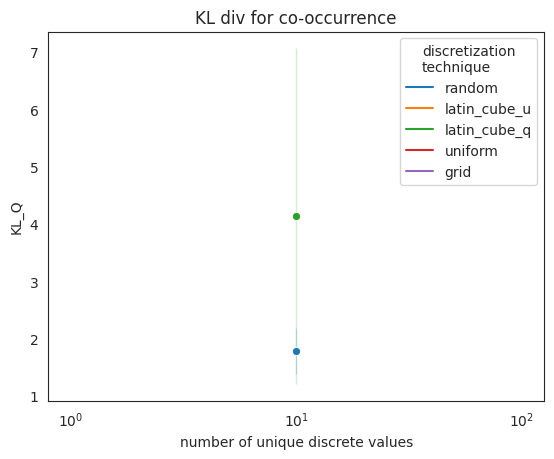

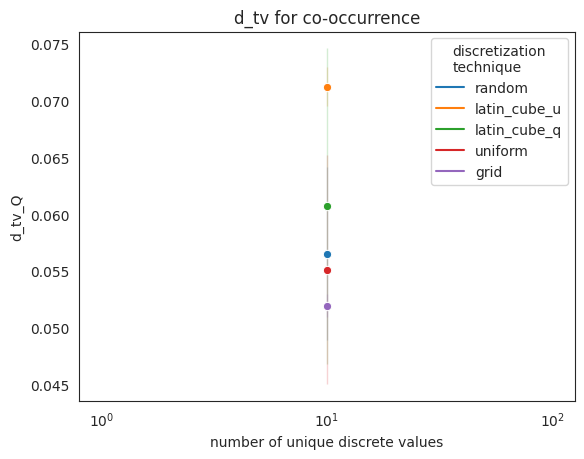

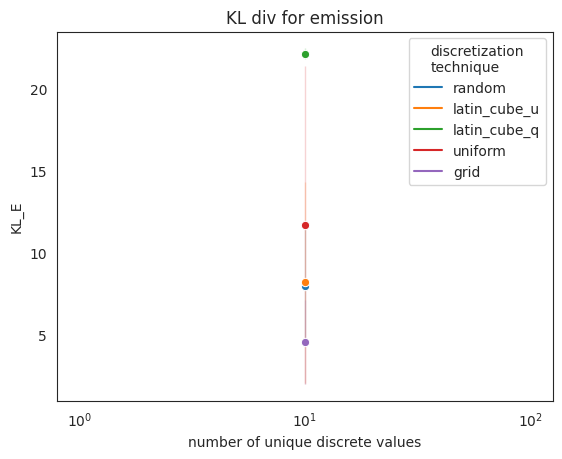

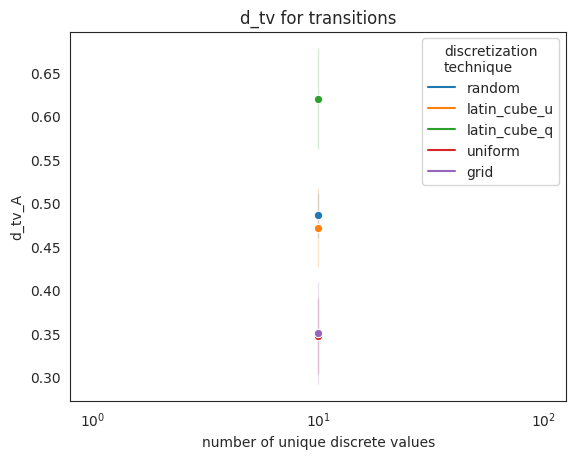

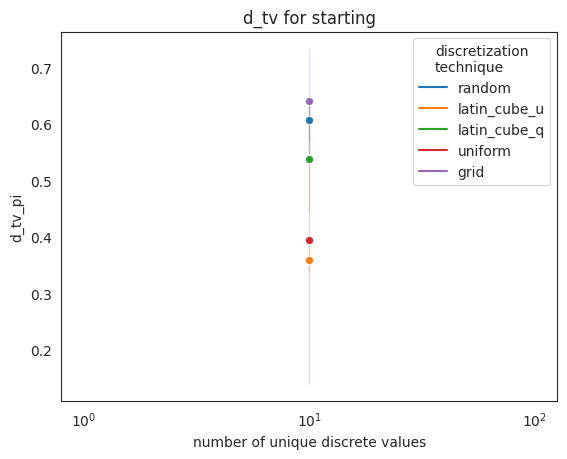

In [22]:
for col in titles.keys():
    sns.lineplot(results, x='n', y=col, hue='disc', marker='o')
    plt.title(titles[col])
    plt.xlabel('number of unique discrete values')
    plt.legend(title="discretization\ntechnique")
    plt.xscale('log')
    plt.savefig(f"{PROJECT_PATH}/theoretical_experiment/plots/2_{col}.png")
    plt.show()